# Daily Passenger Traffic Statistics Forecast

## 1. Environment settings and library import


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

## 2. Data loading and feature engineering

In this section, we will:
1. Read the data and convert the date type;
2. Remove useless columns or missing values ​​(if necessary);
3. Generate additional features (such as day of the week);
4. Then split the data into Arrival and Departure.

In [26]:
df = pd.read_csv('dataset/hkdata_2023_2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['DayOfWeek'] = df['Date'].dt.dayofweek
features = ['Control Point', 'Arrival / Departure', 'DayType', 'Quarter', 'DayOfWeek', 'Year']
target = 'Total'

print(df.dtypes)
display(df.head(10))

Date                   datetime64[ns]
Control Point                  object
Arrival / Departure            object
Hong Kong Residents             int64
Mainland Visitors               int64
Other Visitors                  int64
Total                           int64
DayType                        object
Year                            int64
Quarter                        object
DayOfWeek                       int32
dtype: object


,Date,Control Point,Arrival / Departure,Hong Kong Residents,Mainland Visitors,Other Visitors,Total,DayType,Year,Quarter,DayOfWeek
0,2023-01-01,Airport,Arrival,24925,1687,2456,29068,Weekend,2023,Q1,6
1,2023-01-01,Airport,Departure,14591,1648,4644,20883,Weekend,2023,Q1,6
2,2023-01-01,Express Rail Link West Kowloon,Arrival,0,0,0,0,Weekend,2023,Q1,6
3,2023-01-01,Express Rail Link West Kowloon,Departure,0,0,0,0,Weekend,2023,Q1,6
4,2023-01-01,Hung Hom,Arrival,0,0,0,0,Weekend,2023,Q1,6
5,2023-01-01,Hung Hom,Departure,0,0,0,0,Weekend,2023,Q1,6
6,2023-01-01,Lo Wu,Arrival,0,0,0,0,Weekend,2023,Q1,6
7,2023-01-01,Lo Wu,Departure,0,0,0,0,Weekend,2023,Q1,6
8,2023-01-01,Lok Ma Chau Spur Line,Arrival,0,0,0,0,Weekend,2023,Q1,6
9,2023-01-01,Lok Ma Chau Spur Line,Departure,0,0,0,0,Weekend,2023,Q1,6


In [27]:
# split
df_arrival = df[df['Arrival / Departure'] == 'Arrival'].copy()
df_departure = df[df['Arrival / Departure'] == 'Departure'].copy()

print("Arrival data shape:", df_arrival.shape)
print("Departure data shape:", df_departure.shape)

Arrival data shape: (10811, 11)
Departure data shape: (10811, 11)


In [28]:
print("X.shape:", X.shape)
display(X.head(10))
print("Feature columns:", X.columns.tolist())

X.shape: (21622, 21)


,DayOfWeek,Year,Control Point_China Ferry Terminal,Control Point_Express Rail Link West Kowloon,Control Point_Harbour Control,Control Point_Heung Yuen Wai,Control Point_Hong Kong-Zhuhai-Macao Bridge,Control Point_Hung Hom,Control Point_Kai Tak Cruise Terminal,Control Point_Lo Wu,...,Control Point_Lok Ma Chau Spur Line,Control Point_Macau Ferry Terminal,Control Point_Man Kam To,Control Point_Sha Tau Kok,Control Point_Shenzhen Bay,Arrival / Departure_Departure,DayType_Weekend,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,6,2023,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,6,2023,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
2,6,2023,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,6,2023,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
4,6,2023,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
5,6,2023,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,True,False,False,False
6,6,2023,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
7,6,2023,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,True,False,False,False
8,6,2023,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
9,6,2023,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,True,False,False,False


Feature columns: ['DayOfWeek', 'Year', 'Control Point_China Ferry Terminal', 'Control Point_Express Rail Link West Kowloon', 'Control Point_Harbour Control', 'Control Point_Heung Yuen Wai', 'Control Point_Hong Kong-Zhuhai-Macao Bridge', 'Control Point_Hung Hom', 'Control Point_Kai Tak Cruise Terminal', 'Control Point_Lo Wu', 'Control Point_Lok Ma Chau', 'Control Point_Lok Ma Chau Spur Line', 'Control Point_Macau Ferry Terminal', 'Control Point_Man Kam To', 'Control Point_Sha Tau Kok', 'Control Point_Shenzhen Bay', 'Arrival / Departure_Departure', 'DayType_Weekend', 'Quarter_Q2', 'Quarter_Q3', 'Quarter_Q4']


## 3. Feature Selection

Example with "Arrival" - Feature Engineering, Random Forest, Feature Selection, and Hyperparameter Tuning
We will now demonstrate how to handle `df_arrival`. We can follow the same procedure for `df_departure`.

### One-Hot Encodoing

In [29]:
features = [
    'Control Point',
    'DayType',
    'Year',
    'Quarter',
    'DayOfWeek'
]
target = 'Total'

X_arrival = pd.get_dummies(df_arrival[features], drop_first=True)
y_arrival = df_arrival[target]

X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_arrival, y_arrival, test_size=0.2, random_state=42)

### Random forest feature selection and parameter adjustment

In this section, we will:
1. Train a random forest model to obtain feature importance;
2. Remove low-contribution features based on feature importance;
3. Adjust important hyperparameters of random forest through grid search (GridSearchCV) to prevent overfitting and improve model performance.

In [30]:
base_rf_a = RandomForestRegressor(random_state=42)
base_rf_a.fit(X_a_train, y_a_train)

importances = base_rf_a.feature_importances_
feature_names = X_a_train.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_imp_df)

                                         Feature  Importance
9                            Control Point_Lo Wu    0.262531
11           Control Point_Lok Ma Chau Spur Line    0.207960
10                     Control Point_Lok Ma Chau    0.065056
15                    Control Point_Shenzhen Bay    0.053735
1                                      DayOfWeek    0.048505
0                                           Year    0.047249
3   Control Point_Express Rail Link West Kowloon    0.039442
12            Control Point_Macau Ferry Terminal    0.038671
6    Control Point_Hong Kong-Zhuhai-Macao Bridge    0.038383
7                         Control Point_Hung Hom    0.032746
5                   Control Point_Heung Yuen Wai    0.030428
13                      Control Point_Man Kam To    0.027830
2             Control Point_China Ferry Terminal    0.018899
19                                    Quarter_Q4    0.018034
8          Control Point_Kai Tak Cruise Terminal    0.013930
18                      

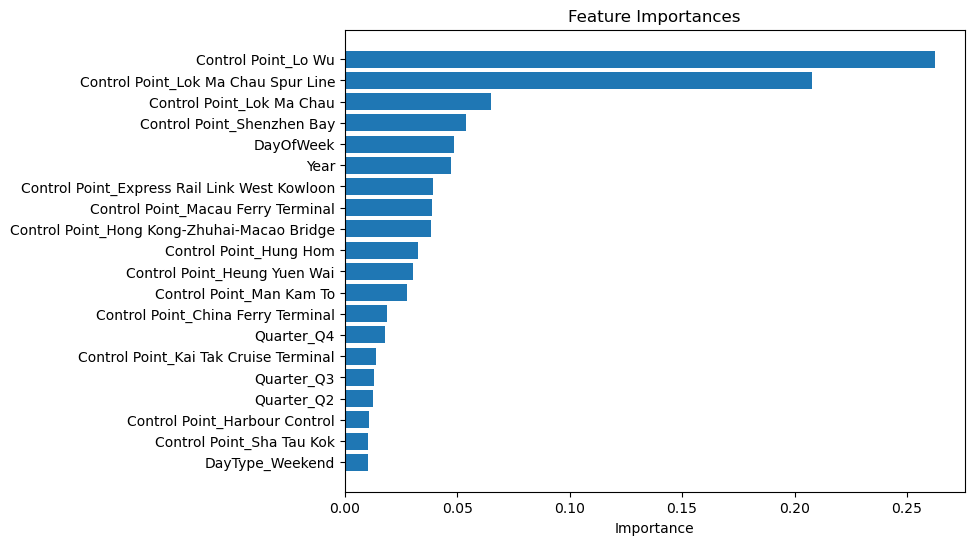

In [31]:
feature_imp_df.sort_values(by='Importance', ascending=True, inplace=True)

plt.figure(figsize=(8,6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

A more systematic approach is to **loop over multiple thresholds**, each time selecting a subset of features that meet the threshold, training the model and evaluating its performance using cross-validation, and finally selecting the threshold that performs best on the validation set.

In [35]:
X_all = X_a_train
y_all = y_a_train

thresholds = np.linspace(0.0, 0.015, 16)
best_score = float("inf")
best_thresh = None

for t in thresholds:
    # Filter features according to the current threshold
    feats = feature_imp_df[feature_imp_df["Importance"] >= t]["Feature"].tolist()
    if len(feats) == 0:
        continue

    X_subset = X_all[feats]
    rf_temp = RandomForestRegressor(random_state=42)
    scores = cross_val_score(
        rf_temp,
        X_subset,
        y_all,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring="neg_mean_squared_error",
    )
    rmse = np.sqrt(-scores.mean())
    print(f"Threshold={t:.3f}, Selected={len(feats)} features, CV RMSE={rmse:.4f}")

    if rmse < best_score:
        best_score = rmse
        best_thresh = t

print("\nBest threshold:", best_thresh)
print("Corresponding CV RMSE:", best_score)

Threshold=0.000, Selected=20 features, CV RMSE=7506.7732
Threshold=0.001, Selected=20 features, CV RMSE=7506.7732
Threshold=0.002, Selected=20 features, CV RMSE=7506.7732
Threshold=0.003, Selected=20 features, CV RMSE=7506.7732
Threshold=0.004, Selected=20 features, CV RMSE=7506.7732
Threshold=0.005, Selected=20 features, CV RMSE=7506.7732
Threshold=0.006, Selected=20 features, CV RMSE=7506.7732
Threshold=0.007, Selected=20 features, CV RMSE=7506.7732
Threshold=0.008, Selected=20 features, CV RMSE=7506.7732
Threshold=0.009, Selected=20 features, CV RMSE=7506.7732
Threshold=0.010, Selected=20 features, CV RMSE=7506.7732
Threshold=0.011, Selected=17 features, CV RMSE=13700.7097
Threshold=0.012, Selected=17 features, CV RMSE=13700.7097
Threshold=0.013, Selected=16 features, CV RMSE=13824.5827
Threshold=0.014, Selected=14 features, CV RMSE=14451.5845
Threshold=0.015, Selected=14 features, CV RMSE=14451.5845

Best threshold: 0.0
Corresponding CV RMSE: 7506.7731767112455


We applied feature selection using Random Forest feature importance and evaluated different thresholds with 5-fold cross-validation. The results showed that retaining all 20 features yielded the lowest CV RMSE (7506.77). Removing features with lower importance led to a significant drop in model performance. Therefore, we decided to retain all features for the final model.

## 4. Model and Prediction

In this step, we build a baseline RandomForestRegressor model using the full set of selected features for the Arrival dataset. We will evaluate the model on the test set using RMSE, MAE, and R² as metrics. This serves as a baseline for comparison with future improvements (e.g., hyperparameter tuning, lag features, pipelines).

### Arrival’s random forest baseline model (baseline)

In [39]:
baseline_rf = RandomForestRegressor(random_state=42)
baseline_rf.fit(X_a_train, y_a_train)

y_a_pred = baseline_rf.predict(X_a_test)

rmse = mean_squared_error(y_a_test, y_a_pred)
mae = mean_absolute_error(y_a_test, y_a_pred)
r2 = r2_score(y_a_test, y_a_pred)

print(f"[Arrival] Baseline RandomForest Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

[Arrival] Baseline RandomForest Performance:
RMSE: 65338909.95
MAE: 3856.06
R²: 0.9169
